<a href="https://colab.research.google.com/github/eduion/DeepRL/blob/main/HW3/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

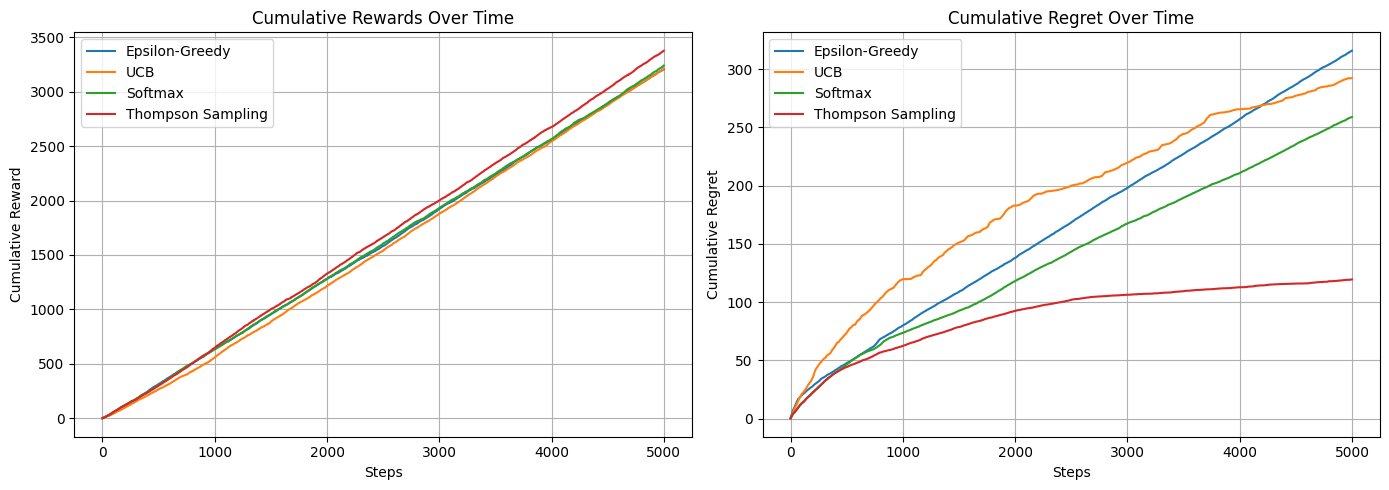

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# 固定期望值
FIXED_TRUE_MEANS = [0.5, 0.2, 0.6, 0.35, 0.7]


# Bandit 環境定義
class Bandit:
    def __init__(self, true_means):
        self.q_true = np.array(true_means)
        self.k = len(true_means)
        self.best_action = np.argmax(self.q_true)

    def pull(self, action):
        return np.random.normal(self.q_true[action], 1)

# 四種演算法
class EpsilonGreedy:
    def __init__(self, k, epsilon):
        self.k = k
        self.epsilon = epsilon
        self.q_est = np.zeros(k)
        self.action_count = np.zeros(k)

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.k)
        return np.argmax(self.q_est)

    def update(self, action, reward):
        self.action_count[action] += 1
        self.q_est[action] += (reward - self.q_est[action]) / self.action_count[action]

class UCB:
    def __init__(self, k, c):
        self.k = k
        self.c = c
        self.q_est = np.zeros(k)
        self.action_count = np.zeros(k)
        self.t = 0

    def select_action(self):
        self.t += 1
        if 0 in self.action_count:
            return np.argmin(self.action_count)
        ucb = self.q_est + self.c * np.sqrt(np.log(self.t) / self.action_count)
        return np.argmax(ucb)

    def update(self, action, reward):
        self.action_count[action] += 1
        self.q_est[action] += (reward - self.q_est[action]) / self.action_count[action]

class Softmax:
    def __init__(self, k, tau):
        self.k = k
        self.tau = tau
        self.q_est = np.zeros(k)
        self.action_count = np.zeros(k)

    def select_action(self):
        exp_q = np.exp(self.q_est / self.tau)
        probs = exp_q / np.sum(exp_q)
        return np.random.choice(self.k, p=probs)

    def update(self, action, reward):
        self.action_count[action] += 1
        self.q_est[action] += (reward - self.q_est[action]) / self.action_count[action]

class ThompsonSampling:
    def __init__(self, k):
        self.k = k
        self.alpha = np.ones(k)
        self.beta = np.ones(k)

    def select_action(self):
        samples = np.random.beta(self.alpha, self.beta)
        return np.argmax(samples)

    def update(self, action, reward):
        if reward > 0:
            self.alpha[action] += 1
        else:
            self.beta[action] += 1

# 模擬器：固定 true_means、可設定 runs 次數
def simulate_with_fixed_means(algo_class, true_means, steps=1000, runs=1, **kwargs):
    np.random.seed(42)
    k = len(true_means)
    rewards = np.zeros((runs, steps))
    regrets = np.zeros((runs, steps))
    for run in range(runs):
        bandit = Bandit(true_means)
        best_reward = np.max(bandit.q_true)
        algo = algo_class(k, **kwargs) if kwargs else algo_class(k)
        for t in range(steps):
            action = algo.select_action()
            reward = bandit.pull(action)
            if isinstance(algo, ThompsonSampling):
                reward_bin = 1 if reward > 0 else 0
                algo.update(action, reward_bin)
            else:
                algo.update(action, reward)
            rewards[run, t] = reward
            regrets[run, t] = best_reward - bandit.q_true[action]
    return rewards.cumsum(axis=1).mean(axis=0), regrets.cumsum(axis=1).mean(axis=0)

# 執行模擬 + 畫圖
def run_all_algorithms(true_means, steps=1000, runs=1):
    eg_cum, eg_regret = simulate_with_fixed_means(EpsilonGreedy, true_means, steps, runs, epsilon=0.1)
    ucb_cum, ucb_regret = simulate_with_fixed_means(UCB, true_means, steps, runs, c=2)
    sm_cum, sm_regret = simulate_with_fixed_means(Softmax, true_means, steps, runs, tau=0.1)
    ts_cum, ts_regret = simulate_with_fixed_means(ThompsonSampling, true_means, steps, runs)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(eg_cum, label='Epsilon-Greedy')
    ax1.plot(ucb_cum, label='UCB')
    ax1.plot(sm_cum, label='Softmax')
    ax1.plot(ts_cum, label='Thompson Sampling')
    ax1.set_title("Cumulative Rewards Over Time")
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Cumulative Reward")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(eg_regret, label='Epsilon-Greedy')
    ax2.plot(ucb_regret, label='UCB')
    ax2.plot(sm_regret, label='Softmax')
    ax2.plot(ts_regret, label='Thompson Sampling')
    ax2.set_title("Cumulative Regret Over Time")
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Cumulative Regret")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

run_all_algorithms(FIXED_TRUE_MEANS, steps=5000, runs=5)
